# Object Detection for Traffic Sign Localization and Classification

by Alvaro Castillejo Arjona

CNN model using transfer learning to both locate and classify traffic signs using the German Traffic Sign Recognition Benchmark (GTSRB) dataset

In [1]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import kagglehub
import pathlib
import pickle
import pandas as pd

/Users/alvarocastillejo/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data import

Import dataset using kagglehub from <https://www.kaggle.com/datasets/harbhajansingh21/german-traffic-sign-dataset>

In [2]:
path = kagglehub.dataset_download("harbhajansingh21/german-traffic-sign-dataset")

print("Path to dataset files:", path)

data_dir = pathlib.Path(path)

train_dir = data_dir / "train.p"
test_dir  = data_dir / "test.p"


def load_data(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
    return data['features'], data['labels']

train_images, train_labels = load_data(os.path.join(path, "train.p"))
valid_images, valid_labels = load_data(os.path.join(path, "valid.p"))
test_images, test_labels   = load_data(os.path.join(path, "test.p"))

sign_df = pd.read_csv(os.path.join(path, "signname.csv"))
class_names = sign_df["SignName"].tolist()

Path to dataset files: /Users/alvarocastillejo/.cache/kagglehub/datasets/harbhajansingh21/german-traffic-sign-dataset/versions/1


## Data pre-processing & augnmentation

Set constants of the model and transform data using data augmentation

In [3]:
# CONSTANTS

NUM_CLASSES = 43  
CLASSES = 43      
INPUT_SIZE = 96   
CANVAS = 96       
OBJ_SIZE = 72     
BATCH_SIZE = 96   
INPUT_SHAPE = (96, 96, 3) 

# Training preprocessing: augment image, resize it, randomly place it on canvas, and return one-hot label + normalized bbox
def transform(image, label):
    image = tf.cast(image, tf.float32)
    
    # Data augmentaiton: Randomly adjust brightness, contrast, hue, and saturation
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    image = tf.image.random_hue(image, max_delta=0.08) 
    image = tf.image.random_saturation(image, lower=0.6, upper=1.4)
    
    # Resize the sign to the defined object size
    image = tf.image.resize(image, (OBJ_SIZE, OBJ_SIZE))

    # Randomly place the sign on the canvas
    xmin = tf.random.uniform((), 0, CANVAS - OBJ_SIZE, dtype=tf.int32)
    ymin = tf.random.uniform((), 0, CANVAS - OBJ_SIZE, dtype=tf.int32)

    image = tf.image.pad_to_bounding_box(image, ymin, xmin, CANVAS, CANVAS)

    # Normalize Bbox coordinates
    xmin_f = tf.cast(xmin, tf.float32) / CANVAS
    ymin_f = tf.cast(ymin, tf.float32) / CANVAS
    xmax_f = tf.cast(xmin + OBJ_SIZE, tf.float32) / CANVAS
    ymax_f = tf.cast(ymin + OBJ_SIZE, tf.float32) / CANVAS
    bbox = tf.stack([xmin_f, ymin_f, xmax_f, ymax_f])

    return image, (tf.one_hot(label, NUM_CLASSES), bbox)

# Validation preprocessing: resize image, center it on canvas, and return one-hot label + normalized bbox
def transform_val(image, label):
    
    # Standardize validation to match training scale (0-255)
    image = tf.cast(image, tf.float32) 
    image = tf.image.resize(image, (OBJ_SIZE, OBJ_SIZE))

    # Center the sign on the canvas for validation consistency
    xmin = (CANVAS - OBJ_SIZE) // 2
    ymin = (CANVAS - OBJ_SIZE) // 2

    image = tf.image.pad_to_bounding_box(image, ymin, xmin, CANVAS, CANVAS)

    # Bbox coordinates
    xmin_f = xmin / CANVAS
    ymin_f = ymin / CANVAS
    xmax_f = (xmin + OBJ_SIZE) / CANVAS
    ymax_f = (ymin + OBJ_SIZE) / CANVAS
    bbox = tf.stack([xmin_f, ymin_f, xmax_f, ymax_f])

    return image, (tf.one_hot(label, NUM_CLASSES), bbox)



Transform training, validation and test datasets

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(5000)
train_ds = train_ds.map(transform, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
valid_ds = valid_ds.map(transform_val, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(256)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(transform_val, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

2026-02-24 20:59:37.972725: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2026-02-24 20:59:37.972900: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2026-02-24 20:59:37.972909: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2026-02-24 20:59:37.973097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-24 20:59:37.973111: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Visualization Utilities

These functions are used to draw bounding boxes around the digits.

In [5]:
im_width = 96
im_height = 96
use_normalized_coordinates = True
iou_threshold = 0.5


def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=('red',),
                                       thickness=2,
                                       display_str_list=()):
    """
    image: numpy array (96,96,3)
    boxes: [N,4] in format [xmin, ymin, xmax, ymax] normalized
    """

    image_pil = PIL.Image.fromarray(image.astype(np.uint8)).convert("RGB")
    draw = PIL.ImageDraw.Draw(image_pil)

    im_width, im_height = image_pil.size

    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box

        left   = xmin * im_width
        right  = xmax * im_width
        top    = ymin * im_height
        bottom = ymax * im_height

        draw.rectangle(
            [(left, top), (right, bottom)],
            outline=color[i % len(color)],
            width=thickness
        )

        if display_str_list:
            draw.text((left, top - 10),
                      display_str_list[i],
                      fill=color[i % len(color)])

    return np.array(image_pil)


def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color = [],
                                 thickness = 1,
                                 display_str_list = ()):
  """Draws bounding boxes on image.
  Args:
    image: a PIL.Image object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: a list of strings for each bounding box.

  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                               boxes[i, 2], color[i], thickness, display_str_list[i])

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color = 'red',
                               thickness = 1,
                               display_str = None,
                               use_normalized_coordinates = True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = PIL.ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width = thickness, fill = color)

These utilities are used to visualize the data and predictions.

In [6]:
"""
This cell contains helper functions used for visualization
and downloads only.

You can skip reading it, as there is very
little Keras or Tensorflow related code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):

    batch_train_ds = training_dataset.unbatch().batch(N)

    for val_imgs, (val_labels, val_boxes) in validation_dataset.take(1):
        validation_images = val_imgs.numpy()
        validation_labels = np.argmax(val_labels.numpy(), axis=1)
        validation_boxes  = val_boxes.numpy()

    for train_imgs, (train_labels, train_boxes) in batch_train_ds.take(1):
        training_images = train_imgs.numpy()
        training_labels = np.argmax(train_labels.numpy(), axis=1)
        training_boxes  = train_boxes.numpy()

    return (training_images, training_labels, training_boxes,
            validation_images, validation_labels, validation_boxes)


# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (96*n, 96), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*96,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [96, 96*n]), n, axis=1), axis=0), [n, 96*96])
  return font_digits, font_labels


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images,
                              predictions,
                              labels,
                              pred_bboxes,
                              true_bboxes,
                              iou,
                              title):

    n = 10
    indexes = np.random.choice(len(images), size=n)

    plt.figure(figsize=(20,4))
    plt.suptitle(title)

    for i, idx in enumerate(indexes):

        ax = plt.subplot(1, n, i+1)

        # convert to uint8 for drawing
        img = images[idx].astype(np.uint8)

        boxes = []
        colors = []
        names = []

        if len(true_bboxes):
            boxes.append(true_bboxes[idx])
            colors.append('green')
            names.append("true")

        if len(pred_bboxes):
            boxes.append(pred_bboxes[idx])
            colors.append('red')
            names.append("pred")

        if boxes:
            img = draw_bounding_boxes_on_image_array(
                img,
                np.array(boxes),
                color=colors,
                display_str_list=names
            )

        plt.imshow(img)
        plt.axis("off")

        pred_class = predictions[idx]
        true_class = labels[idx]

        title_color = "red" if pred_class != true_class else "black"
        ax.set_title(class_names[pred_class], color=title_color, fontsize=9)

    plt.show()


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=None, smooth=False):
    plt.figure(figsize=(6,4))

    train = history.history[metric_name]
    val   = history.history.get('val_' + metric_name)

    # optional smoothing (helps noisy validation curves)
    if smooth:
        import numpy as np
        def smooth_curve(data, weight=0.6):
            smoothed = []
            last = data[0]
            for point in data:
                last = last * weight + (1 - weight) * point
                smoothed.append(last)
            return smoothed
        train = smooth_curve(train)
        if val:
            val = smooth_curve(val)

    plt.plot(train, label="Train", linewidth=2)

    if val:
        plt.plot(val, label="Validation", linewidth=2)

    plt.title(title, fontsize=14)
    plt.xlabel("Epoch")
    plt.ylabel(metric_name)

    if ylim:
        plt.ylim(0, ylim)

    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Visualize Data

Visualize training and validation data 

2026-02-24 20:59:38.479060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-24 20:59:38.529505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


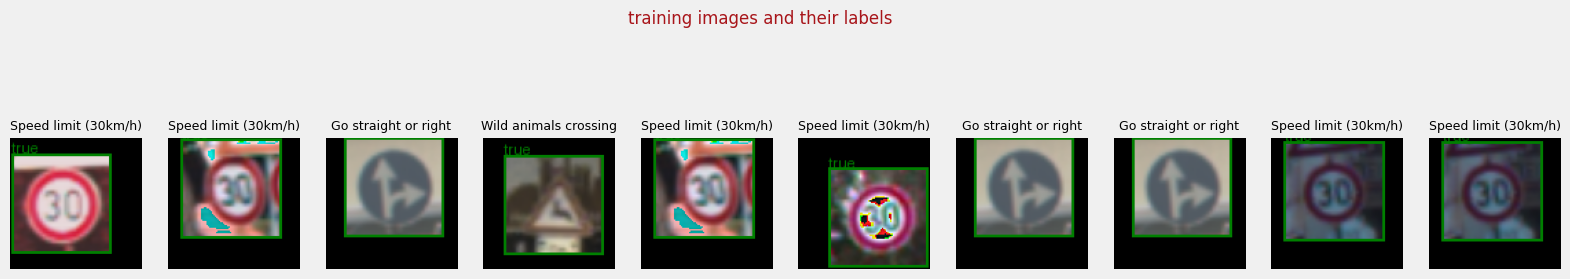

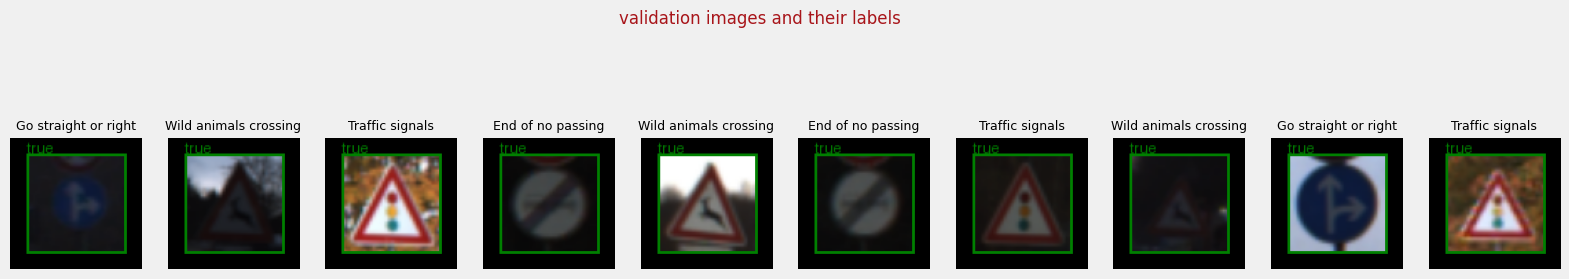

In [7]:
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(train_ds, valid_ds, 10)

display_digits_with_boxes(
    training_digits,
    training_labels,
    training_labels,
    np.array([]),
    training_bboxes,
    np.array([]),
    "training images and their labels"
)

display_digits_with_boxes(
    validation_digits,
    validation_labels,
    validation_labels,
    np.array([]),
    validation_bboxes,
    np.array([]),
    "validation images and their labels"
)


## Build transfer model

In [8]:
def build_transfer_learning_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False 

    inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    
    features = base_model(x, training=False)
    shared = tf.keras.layers.GlobalAveragePooling2D()(features)
    
    # Classification Head
    class_branch = tf.keras.layers.Dense(256, activation='relu')(shared)
    class_branch = tf.keras.layers.BatchNormalization()(class_branch)
    class_branch = tf.keras.layers.Dropout(0.4)(class_branch) 
    class_out = tf.keras.layers.Dense(CLASSES, activation='softmax', name='classifier_head')(class_branch)
    
    # Regression Head
    reg_branch = tf.keras.layers.Dense(128, activation='relu')(shared)
    bbox_out = tf.keras.layers.Dense(4, activation='sigmoid', name='regressor_head')(reg_branch)

    return tf.keras.Model(inputs=inputs, outputs=[class_out, bbox_out])


model = build_transfer_learning_model()

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 96, 96, 3) │          0 │ input_layer_1[0]… │
│ (TrueDivide)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 96, 96, 3) │          0 │ true_divide[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_96 │ (None, 3, 3,      │  2,257,984 │ subtract[0][0]    │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    163,968 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier_head     │ (None, 43)        │     11,051 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regressor_head      │ (None, 4)         │        516 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,762,479 (10.54 MB)

 Trainable params: 503,983 (1.92 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

Compile model

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # Faster start
    loss={"classifier_head": "categorical_crossentropy", "regressor_head": "mse"},
    loss_weights={"classifier_head": 10.0, "regressor_head": 1.0},
    metrics={"classifier_head": "accuracy", "regressor_head": "mse"}
)

### First training phase

First training phase with MobilNetV2 layer frozen to maintain features

In [10]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_classifier_head_loss', # We monitor the head you want to improve
    factor=0.2,                         # Drop LR by 5x when it plateaus
    patience=3,                         # Wait 3 epochs before droppi
    mode='min',
    verbose=1
)


history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[lr_scheduler] # Add it here
)

Epoch 1/10


2026-02-24 20:59:41.729521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


362/362 ━━━━━━━━━━━━━━━━━━━━ 66s 172ms/step - classifier_head_accuracy: 0.6253 - classifier_head_loss: 1.4420 - loss: 14.4417 - regressor_head_loss: 0.0214 - regressor_head_mse: 0.0214 - val_classifier_head_accuracy: 0.3667 - val_classifier_head_loss: 2.9931 - val_loss: 31.2241 - val_regressor_head_loss: 0.0156 - val_regressor_head_mse: 0.0156 - learning_rate: 0.0010
Epoch 2/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 57s 157ms/step - classifier_head_accuracy: 0.6958 - classifier_head_loss: 1.0833 - loss: 10.8535 - regressor_head_loss: 0.0207 - regressor_head_mse: 0.0207 - val_classifier_head_accuracy: 0.4100 - val_classifier_head_loss: 2.5869 - val_loss: 26.9878 - val_regressor_head_loss: 0.0156 - val_regressor_head_mse: 0.0156 - learning_rate: 0.0010
Epoch 3/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 58s 159ms/step - classifier_head_accuracy: 0.7286 - classifier_head_loss: 0.9170 - loss: 9.1906 - regressor_head_loss: 0.0209 - regressor_head_mse: 0.0209 - val_classifier_head_accuracy: 0.4129 - val_classifie

### Second training phase, classifier head fine-tunning

Second training phase with MobilNetV2 layer unfrozen from layer 80 towards

In [11]:
base_model_layer = next(l for l in model.layers if 'mobilenetv2' in l.name)
base_model_layer.trainable = True

for layer in base_model_layer.layers[:80]: 
    layer.trainable = False

# Re-compile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6), 
    loss={"classifier_head": "categorical_crossentropy", "regressor_head": "mse"},
    loss_weights={"classifier_head": 10.0, "regressor_head": 1.0},
    metrics={"classifier_head": "accuracy", "regressor_head": "mse"}
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_classifier_head_accuracy', 
    patience=5, 
    restore_best_weights=True,
    mode='max'
)

history_finetune = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=20,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 149s 374ms/step - classifier_head_accuracy: 0.3563 - classifier_head_loss: 2.8303 - loss: 28.3203 - regressor_head_loss: 0.0173 - regressor_head_mse: 0.0173 - val_classifier_head_accuracy: 0.4580 - val_classifier_head_loss: 2.8066 - val_loss: 29.1442 - val_regressor_head_loss: 0.0091 - val_regressor_head_mse: 0.0091 - learning_rate: 5.0000e-06
Epoch 2/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 130s 359ms/step - classifier_head_accuracy: 0.4662 - classifier_head_loss: 2.0445 - loss: 20.4617 - regressor_head_loss: 0.0170 - regressor_head_mse: 0.0170 - val_classifier_head_accuracy: 0.4934 - val_classifier_head_loss: 2.2894 - val_loss: 23.7037 - val_regressor_head_loss: 0.0098 - val_regressor_head_mse: 0.0098 - learning_rate: 5.0000e-06
Epoch 3/20
362/362 ━━━━━━━━━━━━━━━━━━━━ 134s 369ms/step - classifier_head_accuracy: 0.5329 - classifier_head_loss: 1.6595 - loss: 16.6114 - regressor_head_loss: 0.0167 - regressor_head_mse: 0.0167 - val_classifier_head_accuracy:

### Third training phase, regression head fine-tunning

Third training phase with MobilNetV2 layer unfrozen from layer 80 towards

In [12]:
# Keep the base model unfrozen from layer 80 onwards, just like Phase 2.
# Shift the loss weights to prioritize the MSE!
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Slightly higher than 5e-6 to allow coordinate shifts
    loss={"classifier_head": "categorical_crossentropy", "regressor_head": "mse"},
    loss_weights={"classifier_head": 1.0, "regressor_head": 15.0}, # MASSIVE boost to bounding boxes!
    metrics={"classifier_head": "accuracy", "regressor_head": "mse"}
)

early_stop_mse = tf.keras.callbacks.EarlyStopping(
    monitor='val_regressor_head_mse', # Now we monitor the MSE!
    patience=5,
    restore_best_weights=True,
    mode='min' # We want MSE to go DOWN (unlike accuracy, which we wanted to go UP)
)

history_refinement = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=15, # 15 epochs should be plenty to push it down
    callbacks=[early_stop_mse] 
)

Epoch 1/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 164s 413ms/step - classifier_head_accuracy: 0.8605 - classifier_head_loss: 0.4378 - loss: 0.6455 - regressor_head_loss: 0.0138 - regressor_head_mse: 0.0138 - val_classifier_head_accuracy: 0.7454 - val_classifier_head_loss: 0.7665 - val_loss: 0.9236 - val_regressor_head_loss: 0.0095 - val_regressor_head_mse: 0.0095
Epoch 2/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 135s 372ms/step - classifier_head_accuracy: 0.8669 - classifier_head_loss: 0.4152 - loss: 0.6160 - regressor_head_loss: 0.0134 - regressor_head_mse: 0.0134 - val_classifier_head_accuracy: 0.7558 - val_classifier_head_loss: 0.7293 - val_loss: 0.8830 - val_regressor_head_loss: 0.0091 - val_regressor_head_mse: 0.0092
Epoch 3/15
362/362 ━━━━━━━━━━━━━━━━━━━━ 132s 364ms/step - classifier_head_accuracy: 0.8757 - classifier_head_loss: 0.3913 - loss: 0.5837 - regressor_head_loss: 0.0128 - regressor_head_mse: 0.0128 - val_classifier_head_accuracy: 0.7676 - val_classifier_head_loss: 0.7071 - val_loss: 0.8562

## Metrics

### Regressor head MSE on validation data

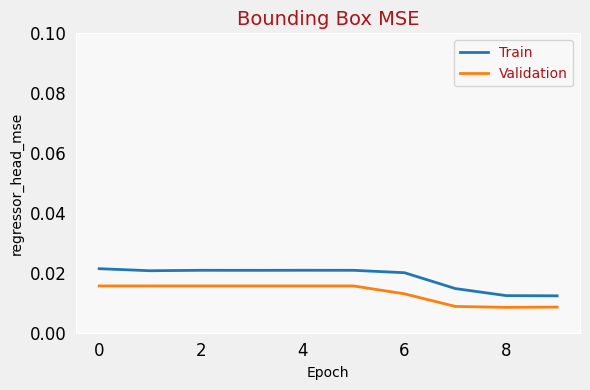

In [13]:
plot_metrics("regressor_head_mse", 
             "Bounding Box MSE", 
             ylim=0.1)


### Classifier accuracy plots on validation data

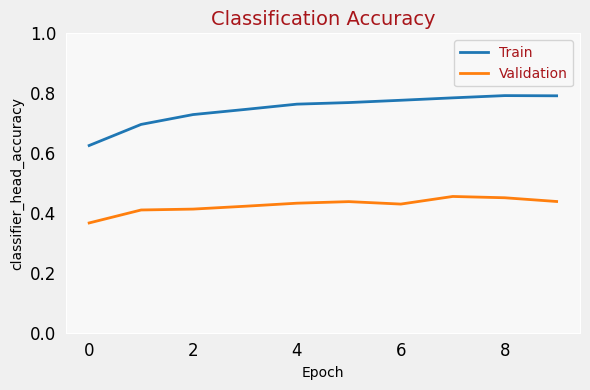

In [14]:
plot_metrics("classifier_head_accuracy",
             "Classification Accuracy",
             ylim=1)

### Intersection over union

Calculate the I-O-U metric to evaluate the model's performance.

In [15]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

In [16]:

predictions = model.predict(validation_digits, batch_size=96)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 957ms/step
Number of predictions where iou > threshold(0.5): 255
Number of predictions where iou < threshold(0.5): 1


### Visualize predictions
The following code will make predictions and visualize both the classification and the predicted bounding boxes.
- The true bounding box labels will be in green, and the model's predicted bounding boxes are in red.
- The predicted number is shown below the image.

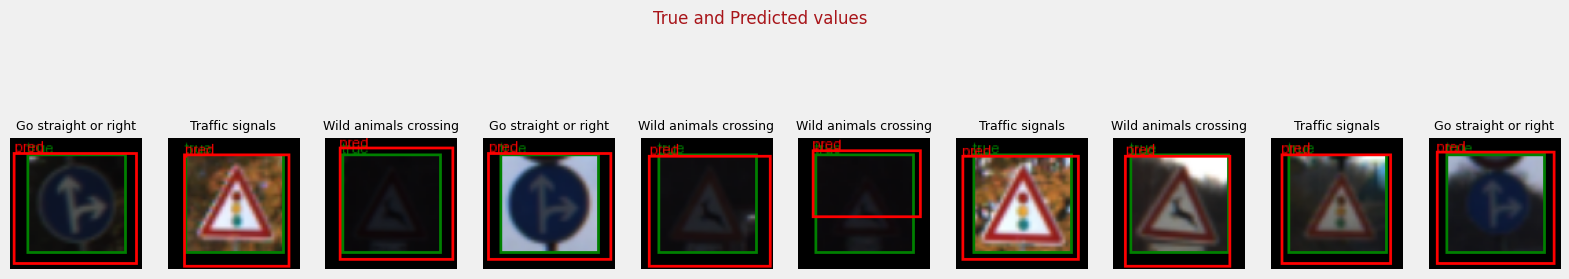

In [17]:
display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")


--- Performing Final Evaluation on Unseen Test Set ---
132/132 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - classifier_head_accuracy: 0.8337 - classifier_head_loss: 0.5023 - loss: 0.5708 - regressor_head_loss: 0.0046 - regressor_head_mse: 0.0046
Test Total Loss: 0.5708
Test Accuracy (Classification): 83.37%
Test MSE (Bounding Box): 0.0046


2026-02-24 22:34:04.958390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


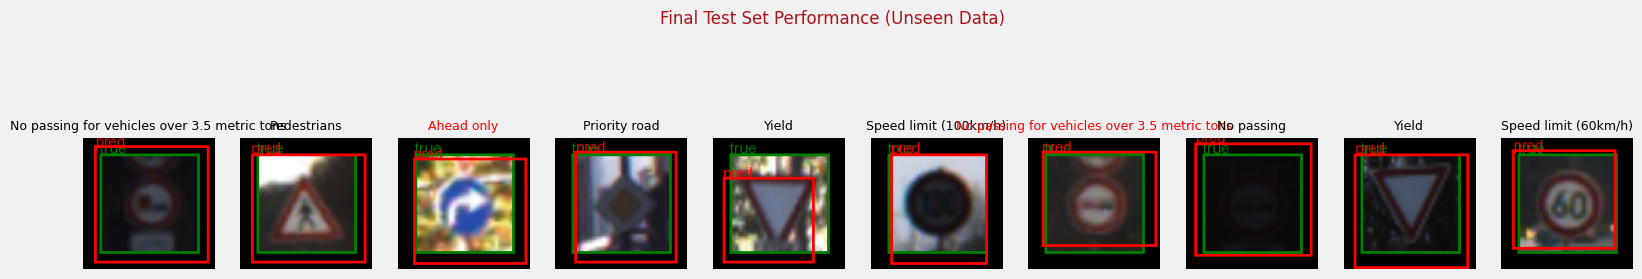

In [18]:
# Run the Evaluation
print("\n--- Performing Final Evaluation on Unseen Test Set ---")
test_results = model.evaluate(test_ds)

# The results order: [loss, classifier_loss, regressor_loss, classifier_accuracy, regressor_mse]
print(f"Test Total Loss: {test_results[0]:.4f}")
print(f"Test Accuracy (Classification): {test_results[3]*100:.2f}%")
print(f"Test MSE (Bounding Box): {test_results[4]:.4f}")

# Visualize Predictions on the Test Set
for test_imgs, (test_labels_oh, test_boxes) in test_ds.take(1):
    test_digits_batch = test_imgs.numpy()
    test_actual_labels = np.argmax(test_labels_oh.numpy(), axis=1)
    test_actual_bboxes = test_boxes.numpy()

# Run predictions on this batch
test_predictions = model.predict(test_digits_batch)
test_predicted_labels = np.argmax(test_predictions[0], axis=1)
test_predicted_bboxes = test_predictions[1]

# Calculate IOU (Intersection Over Union) for the test batch
test_iou = intersection_over_union(test_predicted_bboxes, test_actual_bboxes)

# Display the results
display_digits_with_boxes(
    test_digits_batch, 
    test_predicted_labels, 
    test_actual_labels, 
    test_predicted_bboxes, 
    test_actual_bboxes, 
    test_iou, 
    "Final Test Set Performance (Unseen Data)"
)

## Save the model

In [19]:
# Save the entire model (architecture, weights, and optimizer state)
model.save('traffic_sign_model_final.keras')

# Also save just the weights as a backup
model.save_weights('traffic_sign_weights_final.weights.h5')

print("Model saved successfully as 'traffic_sign_model_final.keras'")

Model saved successfully as 'traffic_sign_model_final.keras'
